# How would thrombolysis use change if clinical decisions were made by hospitals with the highest current thrombolysis rate?

## Aims

* Investigate changes in thrombolysis use (for patients arriving within 4 hours of known onset) if the decision to thrombolyse is made by the 30 hospitals with the highest current thrombolysis rate.

* Compare this to changes in thrombolysis use when the decision is made by a benchmark set of hospitals (those 30 hospitals which have the highest preidcted thrombolysis use in a standard corhort of patients; see separate NoteBook)

## Import libraries 

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.lines import Line2D

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

### Load pre-trained hospital models into dictionary `hospital2model` 

keys = hospitals

values = trained_classifier, threshold, patients, outcomes

In [3]:
with open ('./models/trained_hospital_models.pkl', 'rb') as f:
    hospital2model = pkl.load(f)

## Load data

Create combined data set by combining cohort train/test

In [4]:
data = pd.concat([
    pd.read_csv('./../data/10k_training_test/cohort_10000_train.csv'),
    pd.read_csv('./../data/10k_training_test/cohort_10000_test.csv')],
    axis=0)

data = data.sample(frac=1.0, random_state=42)

hospitals = list(set(data['StrokeTeam'].values))

## Find 30 hospitals with highest thrombolysis rate

These are the hospitals with highest actual thrombolysis use.

In [5]:
hospitals = list(hospital2model.keys())

In [6]:
rates = []

for h in hospitals:
    
    patients = data.loc[data['StrokeTeam']==h]
    
    rate = sum(patients['S2Thrombolysis'].values)/len(patients)
    
    rates.append([h,rate])

In [7]:
rates = sorted(rates, key=lambda x: x[1], reverse=True)

In [8]:
sorted_hospitals, true_rates = zip(*rates)

In [9]:
top_hospitals = sorted_hospitals[:30]

## Put patients from all other hospitals through top hospitals 

In [10]:
columns = np.concatenate((['Hospital','True', 'Majority'], top_hospitals)) 

results_top = pd.DataFrame(columns = columns)


for hospital in hospitals:
    
    patients = data.loc[data['StrokeTeam']==hospital]
    
    y = patients['S2Thrombolysis'].values
    X = patients.drop(['StrokeTeam', 'S2Thrombolysis'], axis=1)
    
    hospital_results = pd.DataFrame(columns = columns)           
        
    for top_hospital in top_hospitals:

        model, threshold, _, _ = hospital2model[top_hospital]
        
        y_prob = model.predict_proba(X)[:,1]
        
        y_pred = [1 if p >= threshold else 0 for p in y_prob]

        hospital_results[top_hospital] = y_pred

        
    hospital_results['Hospital'] = [hospital for person in y]
    hospital_results['True'] = y
    

    results_top = results_top.append(hospital_results, ignore_index=True)

### Add majority outcome 

In [11]:
majority_threshold = 15/30

for index,row in results_top.iterrows():
    

    no = sum([1 for val in row[3:].values if val ==0])
    yes = sum(row[3:].values)
    
    
    if yes/(no+yes)>=majority_threshold:
        
        results_top.loc[index, 'Majority'] = 1
        
    else:
        
        results_top.loc[index, 'Majority'] = 0

### Find new thrombolysis rates

Find thrombolysis use rates for each hospital if the decision to thrombolyse for their patients was made by a majority vote of 30 hospitals with the current highest thrombolysis use.

In [12]:
# Get current and 'top 30 majority' vote thrombolysis use rates
top_30_results = (results_top.groupby('Hospital')['True', 'Majority'].sum() /
                  results_top.groupby('Hospital')['True', 'Majority'].count())

# Add in admissions
top_30_results['admissions'] = results_top.groupby('Hospital').count()['True']

# Add in whether hospital is in top 30
top_30_results['top_30'] = [x in top_hospitals for x in top_30_results.index ]

# Show DataFrame
top_30_results

,True,Majority,admissions,top_30
Hospital,,,,
AGNOF1041H,0.352064,0.433486,872,True
AKCGO9726K,0.369748,0.313725,1428,True
AOBTM3098N,0.218803,0.305983,585,False
APXEE8191H,0.226481,0.238676,574,False
ATDID5461S,0.239617,0.255591,313,False
...,...,...,...,...
YPKYH1768F,0.246057,0.312303,317,False
YQMZV4284N,0.236170,0.236170,470,False
ZBVSO0975W,0.250000,0.363426,432,False


### Plot  

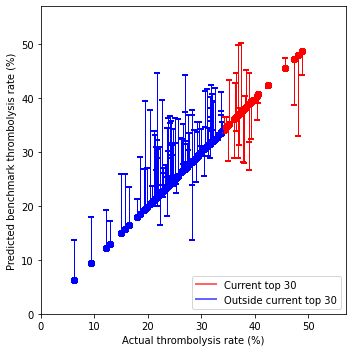

In [13]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()

# Plot non-benchmark hospitals in blue
mask = top_30_results['top_30'] == False
non_bench = top_30_results[mask]

for i, val in non_bench.iterrows():
    # Plot lines
    ax.plot([non_bench['True'] * 100,
             non_bench['True'] * 100],
            [non_bench['True'] * 100,
             non_bench['Majority'] * 100],
            color='b', lw=0.5, alpha=0.6)
    
    # Add markers separately
    ax.scatter(non_bench['True'] * 100, 
               non_bench['True'] * 100,
               marker='o',
               color='b',
               zorder=2)
    
    ax.scatter(non_bench['True'] * 100, 
               non_bench['Majority'] * 100,
               marker='_',
               color='b',
               zorder=2) 

# Plot benchmark hospitals in red
# Plot non-benchmark hospitals in blue
mask = top_30_results['top_30'] == True
bench = top_30_results[mask]

for i, val in bench.iterrows():
    # Plot lines
    ax.plot([bench['True'] * 100,
             bench['True'] * 100],
            [bench['True'] * 100,
             bench['Majority'] * 100],
            color='r', lw=0.5, alpha=0.6)
    
    # Add markers separately
    ax.scatter(bench['True'] * 100, 
               bench['True'] * 100,
               marker='o',
               color='r',
               zorder=2)
    
    ax.scatter(bench['True'] * 100, 
               bench['Majority'] * 100,
               marker='_',
               color='r',
               zorder=2) 


# Add mods 
ax.set_xlabel('Actual thrombolysis rate (%)')
ax.set_ylabel('Predicted benchmark thrombolysis rate (%)')
ax.set_xlim(0, 57)
ax.set_ylim(0, 57)

custom_lines = [Line2D([0], [0], color='r', alpha=0.6, lw=2),
                Line2D([0], [0], color='b', alpha = 0.6,lw=2)]

plt.legend(custom_lines, ['Current top 30', 'Outside current top 30'],
          loc='lower right')

plt.tight_layout()
plt.savefig('output/top_30_actual_thrombolysis.jpg', dpi=300)

plt.show()

### Calculated weighted average

Weight thrombolysis by admission numbers

In [14]:
base_rates = (
    (top_30_results['True'] * top_30_results['admissions']).sum() / 
    top_30_results['admissions'].sum())

top_30_rates = (
    (top_30_results['Majority'] * top_30_results['admissions']).sum() /
    top_30_results['admissions'].sum())

In [15]:
print (f'Baseline thrombolysis: {base_rates*100:0.1f}')
print (f'Top 30 decision thrombolysis: {top_30_rates*100:0.1f}')
ratio = top_30_rates / base_rates
print (f'Ratio of top 30 deiciions to base rate: {ratio:0.3f}')

Baseline thrombolysis: 29.5
Top 30 decision thrombolysis: 32.7
Ratio of top 30 deiciions to base rate: 1.108


## Observations

* When the decision to thrombolyse is made by a majority vote of the top thrombolysing hospitals, the overall thrombolysis rate increases from 29.5% to 32.7%.

* The change in thrombolysis use is signifcantly smaller than if the comparitor hospitals are those 30 hospitals which have the highest preidcted thrombolysis use in a standard corhort of patients (where thrombolysis use is predicted to rise to 36.9%).

* The thrombolysis rate does not increase in all hospitals.